# Practical Machine Learning for Physicists
## Week 2 Exercise - Part 2
## Deadline Monday 9th November at 12pm (Noon)

For both of these tasks we want you to implement autoencoder networks that:
- Train on randomly generated circles (using the circle_generator function below)
- Use 27x27 pixel images
- Use no more than 30,000 randomly generated samples (e.g. batchsize 30 and 1000 steps, or batchsize 1000 and 30 steps, or anywhere inbetween) in training the final networks for each task
- Use the mean_squared_error loss function
- Fulfil the network size requirement listed in the task (can be verifired using the print_layers function, after the network is partially trained)

### Task 1:
Implement any network design, but the bottleneck must contain no more than 9 neurons.

### Task 2:
Implement any network design, but the bottleneck must contain no more than 3 neurons.



#### Practicalities
You should use this notebook for your work and upload it to both Moodle and CoCalc. You are expected to use TensorFlow and Keras to complete these tasks. The notebook should be self-contained and able to be executed if necessary. Marks will be awarded for (roughly equally weighted):
- Overall notebook clarity (both in terms of good coding practice and coherent discussion)
- Task 1 performance (0.02 is a good target cost to do better than)
- Task 2 performance ( a good target here is left for the student to determine)



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs
def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    #print(layer_features)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    

## Circle generator


In [3]:
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)


#[1]

2.6.0


# Task 1:

#### Creating the autoencoder nueral network:

In [5]:
model=keras.models.Sequential()

# 5x5 kernel size, 4 channels in first hidden layer:
model.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1),activation="sigmoid",padding='same')) 
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) #pooling layer with 3x3 DOWNsampling kernal

model.add(keras.layers.Conv2D(4,5, activation="sigmoid",padding='same')) #5x5 kernel size, 4 channels in 2nd conv. layer
model.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) #pooling layer with 3x3 DOWNsampling kernal

model.add(keras.layers.Conv2D(1,3, activation="sigmoid",padding='same')) #3x3 kernal size, 1 chann. in 3rd conv. layer(BOTTLENECK)
model.add(keras.layers.UpSampling2D(size=(3,3)))                       #layer with 3x3 UPsampling kernal

model.add(keras.layers.Conv2D(4,5, activation="sigmoid",padding='same')) #5x5 kernel size, 4 channels in 4th conv. layer
model.add(keras.layers.UpSampling2D(size=(3,3)))                       #layer with 3x3 UPsampling kernal

model.add(keras.layers.Conv2D(4,5, activation="sigmoid",padding='same')) #5x5 kernel size, 4 channels in 5th conv. layer

#Output Layer:
model.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))

#from sequential model to compile model (using mean_squared_error):
model.compile(loss='mean_squared_error', optimizer='adam')

#summarise parameter, ouput shape and layers:
model.summary()


#[1]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 4)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 4)     404       
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     37        
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, None, None, 1)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 4)     1

#### Training and Cost Plot:

The Final Cost Value is: 0.019685612991452217


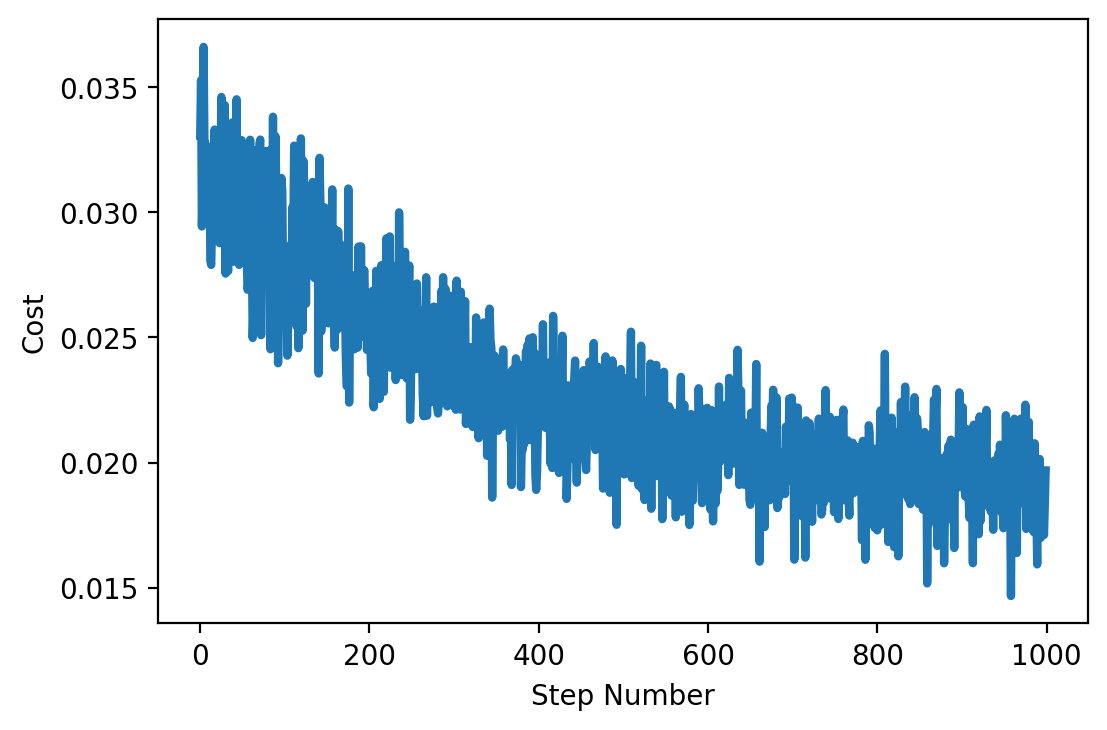

In [7]:
#model training:
steps=1000
cost,y_target=generate_and_train(model,circle_generator,img_size=9*3,batchsize=30,steps=steps)

#Plot the cost
fig, ax = plt.subplots()
stepArray=np.arange(steps) 
ax.plot(stepArray,cost,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

#[1]

print("The Final Cost Value is:", cost[len(cost)-1])

#### Comments:

As you can see, we the cost is below 0.02. We could add more layers to lower the cost even further. However, this would increase computing power usage.

#### Verify How Many Nuerons in Each Layer:

In [8]:
print_layers(model,y_target)

Layer 0: 2916 neurons /  (30, 27, 27, 4)
Layer 1: 324 neurons /  (30, 9, 9, 4)
Layer 2: 324 neurons /  (30, 9, 9, 4)
Layer 3: 36 neurons /  (30, 3, 3, 4)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 324 neurons /  (30, 9, 9, 4)
Layer 7: 2916 neurons /  (30, 27, 27, 4)
Layer 8: 2916 neurons /  (30, 27, 27, 4)
Layer 9: 729 neurons /  (30, 27, 27, 1)


# Task 2:

#### Creating the autoencoder nueral network:

In [9]:
model2=keras.models.Sequential()

# 5x5 kernel size, 4 channels in first hidden layer:
model2.add(keras.layers.Conv2D(4,5,input_shape=(None,None,1), activation="sigmoid",padding='same'))
model2.add(keras.layers.AveragePooling2D(pool_size=(3,3),padding='same')) #pooling layer with 3x3 DOWNsampling kernal

model2.add(keras.layers.Conv2D(8,10, activation="sigmoid",padding='same')) #10x10 kernel size, 8 channels in 2nd conv. layer
model2.add(keras.layers.AveragePooling2D(pool_size=(9,9),padding='same')) #pooling layer with 9x9 DOWNsampling kernal

model2.add(keras.layers.Conv2D(3,3, activation="sigmoid",padding='same')) #3x3 kernal size, 3 chann. in 3rd conv. layer(BOTTLENECK)
model2.add(keras.layers.UpSampling2D(size=(9,9))) #layer with 3x3 UPsampling kernal

model2.add(keras.layers.Conv2D(8,10, activation="sigmoid",padding='same')) #10x10 kernel size, 8 channels in 4th conv. layer
model2.add(keras.layers.UpSampling2D(size=(3,3))) #layer with 3x3 UPsampling kernal

model2.add(keras.layers.Conv2D(4,5, activation="sigmoid",padding='same')) #5x5 kernel size, 4 channels in 5th conv. layer

#Output Layer:
model2.add(keras.layers.Conv2D(1,3,activation="linear",padding='same'))

#from sequential model to compile model (using mean_squared_error):
model2.compile(loss='mean_squared_error', optimizer='adam')

#summarise parameter, ouput shape and layers:
model2.summary()


#[1]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d_2 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 8)     3208      
_________________________________________________________________
average_pooling2d_3 (Average (None, None, None, 8)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 3)     219       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, None, None, 3)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 8)    

#### Training and Cost Plot:

The Final Cost Value is: 0.039193715900182724


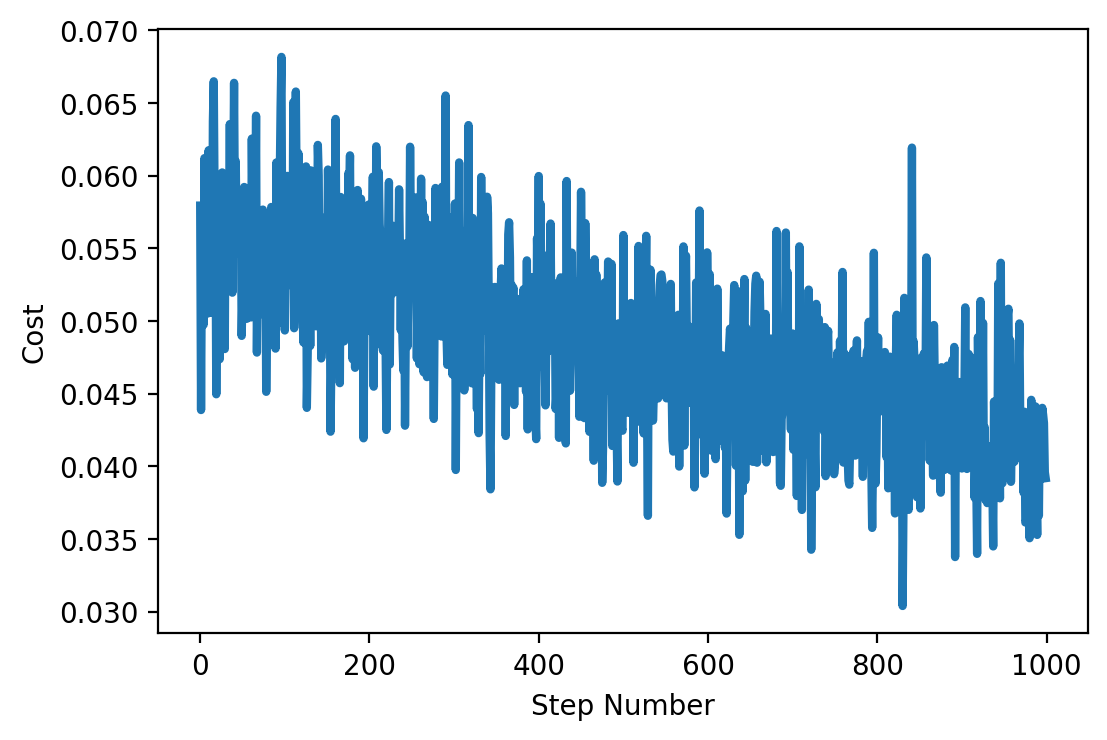

In [13]:
#model training:
steps2=1000
cost2,y_target2=generate_and_train(model2,circle_generator,img_size=9*3,batchsize=30,steps=steps2)

#Plot the cost:
fig, ax = plt.subplots()
stepArray=np.arange(steps2) 
ax.plot(stepArray,cost2,linewidth=3) 
ax.set_xlabel("Step Number") 
ax.set_ylabel("Cost")

#[1]

print("The Final Cost Value is:", cost2[len(cost2)-1])

#### Comments:

As you can see, we the cost is below 0.04. This is a reasonably low cost since we have used less nuerons in our bottleneck, so it is expected that our performance will drop. Considering that the number of nuerons in the bottleneck has decreased by 3x, an increase in cost of 2x is still a low cost. 

#### Verify How Many Nuerons in Each Layer:

In [12]:
print_layers(model2,y_target2)

Layer 0: 2916 neurons /  (30, 27, 27, 4)
Layer 1: 324 neurons /  (30, 9, 9, 4)
Layer 2: 648 neurons /  (30, 9, 9, 8)
Layer 3: 8 neurons /  (30, 1, 1, 8)
Layer 4: 3 neurons /  (30, 1, 1, 3)
Layer 5: 243 neurons /  (30, 9, 9, 3)
Layer 6: 648 neurons /  (30, 9, 9, 8)
Layer 7: 5832 neurons /  (30, 27, 27, 8)
Layer 8: 2916 neurons /  (30, 27, 27, 4)
Layer 9: 729 neurons /  (30, 27, 27, 1)


## Conlusion:

Having more nuerons in the bottleneck of the autoencoder will improve performance. Furthermore, a different activation function and more layers in the activation function could be used. Also, having less nuerons in the bottleneck will increase the number of parameters. Therefore, having more neurons can decrease computing power used as well as improve performance.

# References:

[1]Nichol. R 2021. "Week4_Autoencoder.ipynb". [Online] UCL Moodle resource. Available from https://moodle.ucl.ac.uk/course/view.php?id=6793#section-10 [accessed 2nd November October 2021] 